# Tugas Akhir Prediksi Delay Pesawat
Muhammad Genta Ari Shandi

## About
1. Dataset: dataset.csv
2. Method: LSTM

## Information
- df = real dataset
- df1 = Labeled dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

Using TensorFlow backend.


In [2]:
df = pd.read_csv('dataset.csv')
df = df.drop(['Unnamed: 16'], axis=1)
df.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
0,2019-01-01,12265,"Niagara Falls, NY",14082,"Punta Gorda, FL",1156,1213.0,17.0,1447,1514.0,27.0,0.0,0.0,171.0,181.0,159.0
1,2019-01-01,10257,"Albany, NY",14082,"Punta Gorda, FL",1840,1937.0,57.0,2144,2250.0,66.0,0.0,0.0,184.0,193.0,177.0
2,2019-01-01,14025,"Plattsburgh, NY",11697,"Fort Lauderdale, FL",1329,1320.0,-9.0,1658,1708.0,10.0,0.0,0.0,209.0,228.0,188.0
3,2019-01-01,14761,"Sanford, FL",14025,"Plattsburgh, NY",815,812.0,-3.0,1108,1049.0,-19.0,0.0,0.0,173.0,157.0,142.0
4,2019-01-01,14082,"Punta Gorda, FL",12265,"Niagara Falls, NY",830,849.0,19.0,1111,1128.0,17.0,0.0,0.0,161.0,159.0,136.0


In [3]:
le = LabelEncoder()
df1 = df
df1['ORIGIN_CITY_NAME'] = le.fit_transform(df1['ORIGIN_CITY_NAME'])
df1['DEST_CITY_NAME'] = le.fit_transform(df1['DEST_CITY_NAME'])
df1.head()

,FL_DATE,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
0,2019-01-01,12265,66,14082,81,1156,1213.0,17.0,1447,1514.0,27.0,0.0,0.0,171.0,181.0,159.0
1,2019-01-01,10257,2,14082,81,1840,1937.0,57.0,2144,2250.0,66.0,0.0,0.0,184.0,193.0,177.0
2,2019-01-01,14025,77,11697,34,1329,1320.0,-9.0,1658,1708.0,10.0,0.0,0.0,209.0,228.0,188.0
3,2019-01-01,14761,94,14025,77,815,812.0,-3.0,1108,1049.0,-19.0,0.0,0.0,173.0,157.0,142.0
4,2019-01-01,14082,81,12265,66,830,849.0,19.0,1111,1128.0,17.0,0.0,0.0,161.0,159.0,136.0


In [4]:
df1['FL_DATE'] = pd.to_datetime(df1.FL_DATE)
df1['CRS_DEP_TIME'] = pd.to_datetime(df1['CRS_DEP_TIME'], format='%H%M').dt.time
# df1['CRS_ARR_TIME'] = pd.to_datetime(df1['CRS_ARR_TIME'], format='%H%M').dt.time
df1['FL_DATE'] +=  pd.to_timedelta(df1.CRS_DEP_TIME.astype(str), unit='s')
df1.index = df1.FL_DATE
df1.index.name = 'Date'
df1 = df1.drop('FL_DATE', axis=1)
# df1.to_csv('preprocessed.csv')
df1.head()

,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME
Date,,,,,,,,,,,,,,,
2019-01-01 11:56:00,12265,66,14082,81,11:56:00,1213.0,17.0,1447,1514.0,27.0,0.0,0.0,171.0,181.0,159.0
2019-01-01 18:40:00,10257,2,14082,81,18:40:00,1937.0,57.0,2144,2250.0,66.0,0.0,0.0,184.0,193.0,177.0
2019-01-01 13:29:00,14025,77,11697,34,13:29:00,1320.0,-9.0,1658,1708.0,10.0,0.0,0.0,209.0,228.0,188.0
2019-01-01 08:15:00,14761,94,14025,77,08:15:00,812.0,-3.0,1108,1049.0,-19.0,0.0,0.0,173.0,157.0,142.0
2019-01-01 08:30:00,14082,81,12265,66,08:30:00,849.0,19.0,1111,1128.0,17.0,0.0,0.0,161.0,159.0,136.0


In [5]:
col = df1.columns
X = df1[['ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
         'DEST_CITY_NAME', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CANCELLED', 'DIVERTED',
         'CRS_ELAPSED_TIME']]
y = df1[['DEP_DELAY']]
preprocessed = df1[['DEP_DELAY', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
                    'DEST_CITY_NAME', 'CANCELLED', 'DIVERTED',
                    'CRS_ELAPSED_TIME']]
preprocessed.to_csv('preprocessed.csv')
preprocessed.head()

,DEP_DELAY,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CANCELLED,DIVERTED,CRS_ELAPSED_TIME
Date,,,,,,,,
2019-01-01 11:56:00,17.0,12265,66,14082,81,0.0,0.0,171.0
2019-01-01 18:40:00,57.0,10257,2,14082,81,0.0,0.0,184.0
2019-01-01 13:29:00,-9.0,14025,77,11697,34,0.0,0.0,209.0
2019-01-01 08:15:00,-3.0,14761,94,14025,77,0.0,0.0,173.0
2019-01-01 08:30:00,19.0,14082,81,12265,66,0.0,0.0,161.0


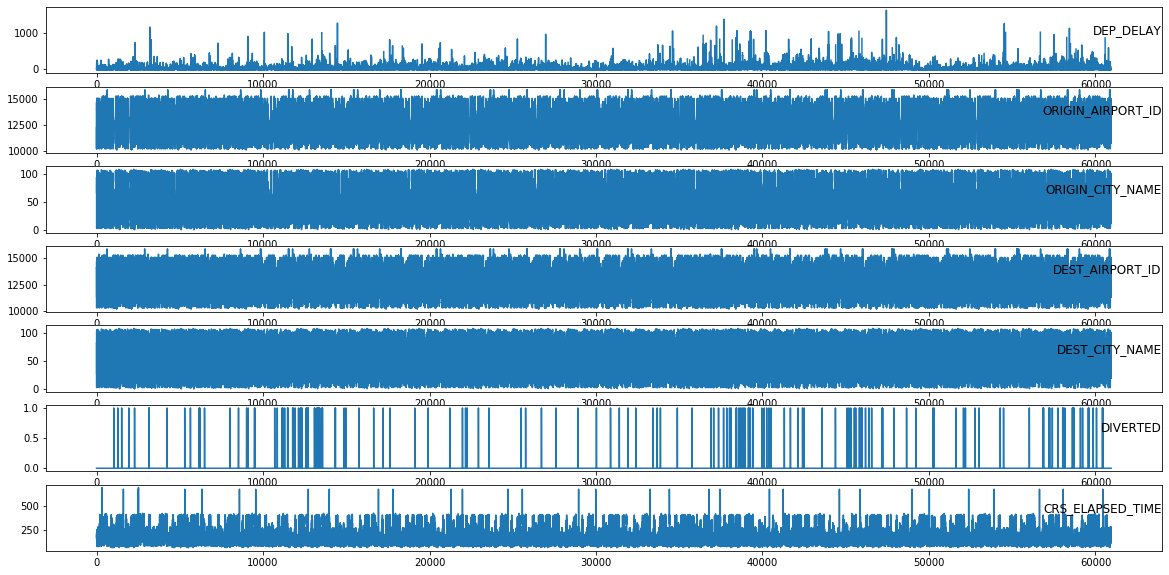

,DEP_DELAY,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST_CITY_NAME,CANCELLED,DIVERTED,CRS_ELAPSED_TIME
Date,,,,,,,,
2019-01-01 11:56:00,17.0,12265,66,14082,81,0.0,0.0,171.0
2019-01-01 18:40:00,57.0,10257,2,14082,81,0.0,0.0,184.0
2019-01-01 13:29:00,-9.0,14025,77,11697,34,0.0,0.0,209.0
2019-01-01 08:15:00,-3.0,14761,94,14025,77,0.0,0.0,173.0
2019-01-01 08:30:00,19.0,14082,81,12265,66,0.0,0.0,161.0


In [6]:
# load dataset
dataset = pd.read_csv('preprocessed.csv', header=0, index_col=0)
# dataset = dataset.apply(le.fit_transform)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(20,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()
dataset.head()

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = pd.read_csv('preprocessed.csv', header=0, index_col=0)
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.031680,0.367711,0.611111,0.682125,0.750000,0.0,0.0,0.179012,0.055589
2,0.055589,0.020246,0.018519,0.682125,0.750000,0.0,0.0,0.199074,0.016139
3,0.016139,0.672262,0.712963,0.269424,0.314815,0.0,0.0,0.237654,0.019725
4,0.019725,0.799619,0.870370,0.672262,0.712963,0.0,0.0,0.182099,0.032875
5,0.032875,0.682125,0.750000,0.367711,0.611111,0.0,0.0,0.163580,0.016736


In [8]:
# split into train and test sets
values = reframed.values
n_train_hours = 2000 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(48000, 1, 8) (48000,) (9121, 1, 8) (9121,)


Train on 48000 samples, validate on 9121 samples
Epoch 1/50
 - 4s - loss: 0.0144 - val_loss: 0.0141
Epoch 2/50
 - 2s - loss: 0.0140 - val_loss: 0.0139
Epoch 3/50
 - 2s - loss: 0.0139 - val_loss: 0.0138
Epoch 4/50
 - 2s - loss: 0.0139 - val_loss: 0.0133
Epoch 5/50
 - 2s - loss: 0.0139 - val_loss: 0.0127
Epoch 6/50
 - 2s - loss: 0.0139 - val_loss: 0.0126
Epoch 7/50
 - 2s - loss: 0.0139 - val_loss: 0.0126
Epoch 8/50
 - 2s - loss: 0.0138 - val_loss: 0.0129
Epoch 9/50
 - 2s - loss: 0.0139 - val_loss: 0.0128
Epoch 10/50
 - 2s - loss: 0.0139 - val_loss: 0.0127
Epoch 11/50
 - 2s - loss: 0.0138 - val_loss: 0.0127
Epoch 12/50
 - 2s - loss: 0.0138 - val_loss: 0.0125
Epoch 13/50
 - 2s - loss: 0.0138 - val_loss: 0.0125
Epoch 14/50
 - 2s - loss: 0.0138 - val_loss: 0.0124
Epoch 15/50
 - 2s - loss: 0.0138 - val_loss: 0.0124
Epoch 16/50
 - 2s - loss: 0.0138 - val_loss: 0.0124
Epoch 17/50
 - 2s - loss: 0.0138 - val_loss: 0.0124
Epoch 18/50
 - 2s - loss: 0.0138 - val_loss: 0.0124
Epoch 19/50
 - 2s - loss

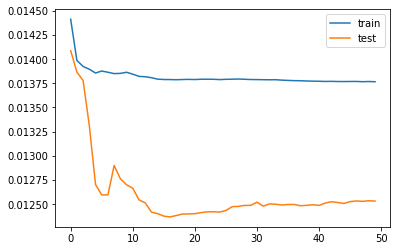

In [9]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [10]:
# make a prediction
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 55.387
